# Торговый робот

### 1. Импортируем библиотеки

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import mplfinance as mpf
from datetime import datetime
from IPython.display import display

### 2. Загружаем датафрейм с finance yahoo

In [3]:
ohlc_df = yf.download('AAPL', start='2017-01-01', end='2021-01-01', 
                      progress=False, parse_dates=['date'], index_col='date')

Выводим на экран наш датафрейм

In [3]:
ohlc_df.head(5).append(ohlc_df.tail(5))

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332470,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301876,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440718,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746634,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000780,134247600
2020-12-24,131.320007,133.460007,131.100006,131.970001,131.161423,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,135.852509,124486200
2020-12-29,138.050003,138.789993,134.339996,134.869995,134.043640,121047300
2020-12-30,135.580002,135.990005,133.399994,133.720001,132.900681,96452100


### 3. Дополняем датафрейм short и long average, а также находим сигналы на покупку/продажу и стоп-лоссы

In [6]:
short_date = 30
long_date = 60

new_df = pd.DataFrame()
main_df = pd.DataFrame()
new_df['Short_Avg30'] = ohlc_df['Close'].rolling(short_date).mean()
new_df['Long_Avg60'] = ohlc_df['Close'].rolling(long_date).mean()

new_df['Benchmark'] = ohlc_df['Close'].cummax()
new_df['TSL'] = new_df.Benchmark * 0.95

new_df['Signals'] = 0.0
new_df['Signals'][short_date:] = np.where(new_df['Short_Avg30'][short_date:] 
                                           > new_df['Long_Avg60'][short_date:], 1.0, 0.0)

new_df['Signals'][short_date:] = np.where(new_df['TSL'][short_date:] 
                                          >= ohlc_df['Low'][short_date:], 1.0, 0.0)

new_df = new_df[~(new_df['Signals'] == 1).shift().fillna(True)]
new_df['Positions'] = new_df['Signals'].diff().shift()

Выводим на экран наш датафрейм

In [7]:
new_df.head(5).append(new_df.tail(5))

,Short_Avg30,Long_Avg60,Benchmark,TSL,Signals,Positions
Date,,,,,,
2017-01-04,NaN,NaN,29.037500,27.585625,0.0,NaN
2017-01-05,NaN,NaN,29.152500,27.694875,0.0,NaN
2017-01-06,NaN,NaN,29.477501,28.003626,0.0,0.0
2017-01-09,NaN,NaN,29.747499,28.260124,0.0,0.0
2017-01-10,NaN,NaN,29.777500,28.288625,0.0,0.0
2020-12-24,122.509333,119.333833,134.179993,127.470993,0.0,-1.0
2020-12-28,123.092000,119.665500,136.690002,129.855502,0.0,0.0
2020-12-29,123.612333,120.029667,136.690002,129.855502,0.0,0.0
2020-12-30,124.059666,120.316667,136.690002,129.855502,0.0,0.0


### 4. Визуализируем лонг и шорт, а также стоп-лоссы, если они срабатывают

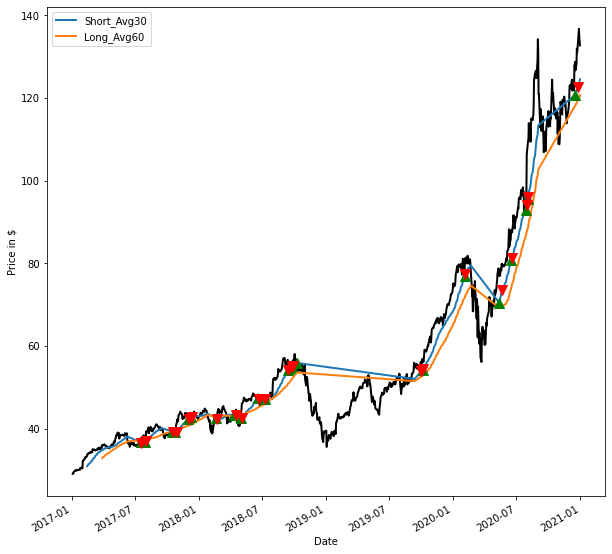

In [8]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111,  ylabel='Price in $')

ohlc_df['Close'].plot(ax=ax1, color='black', lw=2.)
new_df[['Short_Avg30', 'Long_Avg60']].plot(ax=ax1, lw=2.)

ax1.plot(new_df.loc[new_df.Positions == 1.0].index, new_df.Short_Avg30[new_df.Positions == 1.0],
         '^', markersize=10, color='g')
         
ax1.plot(new_df.loc[new_df.Positions == -1.0].index, new_df.Short_Avg30[new_df.Positions == -1.0],
         'v', markersize=10, color='r')
      
plt.show()

### 5. Осуществляем покупки и продажи

In [9]:
initial_capital= float(100000.0)

positions = pd.DataFrame(index=new_df.index).fillna(0.0)

positions['AAPL'] = 100*new_df['Signals']   
  
portfolio = positions.multiply(ohlc_df['Open'], axis=0)

pos_diff = positions.diff()

portfolio['holdings'] = (positions.multiply(ohlc_df['Open'], axis=0)).sum(axis=1)

portfolio['cash'] = initial_capital - (pos_diff.multiply(ohlc_df['Open'], axis=0)).sum(axis=1).cumsum()   

portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

print(portfolio.tail(50))

                    AAPL      holdings           cash          total   returns
Date                                                                          
2020-10-21           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-10-22           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-10-23           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-10-26           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-10-27           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-10-28           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-10-29           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-10-30           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-11-02           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-11-03           NaN      0.000000   88046.750259   88046.750259  0.000000
2020-11-04           NaN      0.000000   88046.75025

### 6. Считаем профит

In [16]:
profit = (portfolio.loc[:, 'total'][len(portfolio)-1] - initial_capital)

print('Профит нашей торговли составил: ', profit)

Профит нашей торговли составил:  1262.7506256103516
